In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import subprocess
sns.__version__ 

'0.11.2'

# paths and files

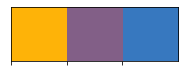

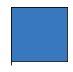

In [2]:
ENHBASE = "/dors/capra_lab/projects/enhancer_ages/encode/data/"

ENCODEPATH = "/dors/capra_lab/data/encode/encode3_hg38/TF/"

RE = "/dors/capra_lab/projects/enhancer_ages/landscape/results/cCRE_x_tfbs_encode3/HepG2/"
RE_DATA = RE + "data/"

if os.path.exists(RE_DATA) == False:
    os.mkdir(RE_DATA)

colors = [ "amber", "dusty purple", "windows blue"]
PAL = sns.xkcd_palette(colors)
sns.palplot(PAL)

colors = [ "windows blue"]
DERPAL = sns.xkcd_palette(colors)
sns.palplot(DERPAL)
#%% Functions

# Functions

## set up variables, paths, format df

In [3]:
def get_cell_lines():
    sample_dict = {
    "HepG2": "ELS_combined_HepG2",
    }

    return sample_dict


def get_paths(cell_line, file_tag, fantombase, encodepath):

    FANTOMPATH = os.path.join(fantombase, file_tag, "ages")
    FANTOMFILE = "syn_breaks_%s_ages.bed" % file_tag
    FANTOM = os.path.join(FANTOMPATH, FANTOMFILE)

    if "CL" in cell_line:
        ENCODEFILE = "cells/" + cell_line.split("_CL")[0] + ".bed.gz"
    elif cell_line == "all_fantom_enh":
        ENCODEFILE = "trimmed_encRegTfbsClusteredWithCells.bed"
    else:
        ENCODEFILE = "cells/" + cell_line + ".bed.gz"

    ENCODE = os.path.join(encodepath, ENCODEFILE)


    INTERSECTIONPATH = os.path.join(fantombase, file_tag)
    INTERSECTIONFILE = "%s_x_ENCODE.bed" % file_tag
    INTERSECTION = os.path.join(INTERSECTIONPATH, INTERSECTIONFILE)

    return FANTOM, ENCODE, INTERSECTION


def bed_intersect(fantom, encode, intersection):

    if os.path.exists(intersection) == False:
        cmd = "bedtools intersect -a %s -b %s -wao > %s" % (fantom, encode, intersection)

        subprocess.call(cmd, shell = True)

        print(cmd)
    else:
        print("previously done enh x encode intersection")


def get_core_age(df):
    core = df.groupby("enh_id")["mrca_2"].max().reset_index()
    core.columns = ["enh_id", 'core_mrca_2']
    df = pd.merge(df, core, how = "left")

    return df


def reEval_PrimComplex(enh):

    # get all the complex enhancers w/ primate core ages
    prComEnhID = enh.loc[(enh.core ==1) &
    (enh.core_remodeling ==1) &
    (enh.taxon2.str.contains("Primate"))]["enh_id"].unique()

    # get all the complex enhancer ids where there is a real human derived sequence
    pr_complex = enh.loc[(enh.enh_id.isin(prComEnhID)) &
    (enh.core_remodeling == 1) &
    (enh.core ==0) &
    (enh.mrca ==0),
    ]["enh_id"]


    # i'm going to reassign any primate complex enhancer
    # where derived regions are from other primates
    # get the set of primate complex enhancers w/ primate derived sequences
    # and rename them as simple enhancers
    pr_simple = set(prComEnhID) - set(pr_complex)

    # reassign core and core remodeling columns
    enh.loc[enh.enh_id.isin(pr_simple), "core"] = 1
    enh.loc[enh.enh_id.isin(pr_simple), "core_remodeling"] = 0
    return enh


def format_df(intersection_file):

    SYN_GROUP = "/dors/capra_lab/projects/enhancer_ages/hg38_syn_taxon.bed"
    syn = pd.read_csv(SYN_GROUP, sep = '\t')

    # round all values
    syn[["mrca", "mrca_2"]] = syn[["mrca", "mrca_2"]].round(3)

    # do the dance - add mrca_2 column, get mrca_2 core age, drop mrca_2 column, then add it back, but this time to reflect the core_age and core taxon, instead of the syntenic age.
    
    cols = ["chr_syn", "start_syn", "end_syn",
    "enh_id","chr", "start", "end",
    "seg_index", "core_remodeling", "core",
    "mrca",
    "chr_tf", "start_tf", "end_tf",
    "tf_id", "peak_len",
    "tf", "cell_line" , "overlap"
    ]

    df = pd.read_csv(intersection_file,
    sep = '\t',
    header = None).drop_duplicates()

    df.columns = cols # add column names
    df = pd.merge(df, syn[["mrca", "mrca_2"]], how = "left")
    df["tf"] = df["tf_id"].apply(lambda x: x.split("_")[0])

    # add architecture label - core, derived, simple
    df["arch"] = "simple"
    df.loc[(df.core_remodeling ==1) & (df.core ==1), "arch"] = "complex_core"
    df.loc[(df.core_remodeling ==1) & (df.core ==0), "arch"] = "complex_derived"
    df.mrca = df.mrca.round(3)
    df = pd.merge(df, syn[["mrca", "mrca_2", "taxon2"]], how = "left")
    df = reEval_PrimComplex(df)

    # add architecture label - complex, simple
    df["overallarch"] = "simple"
    df.loc[df.core_remodeling ==1, "overallarch"] = "complex"

    # add syn identifier
    df["syn_id"] = df.chr_syn + ":" + df.start_syn.map(str) + "-" + df.end_syn.map(str)

    #calculate enhancer and syntenic block length
    df["enh_len"] = df.end - df.start
    df["syn_len"] = df.end_syn - df.start_syn
    df.loc[df.syn_len <6, "syn_len"] = 0


    # binary for TF overlap, any TF that overlaps less than 6bp is not counted.
    df["tfoverlap_bin"] = 1
    df.loc[df.tf == ".", "tfoverlap_bin"] = 0
    df.loc[df.overlap <6 , "tfoverlap_bin"] = 0


    return df

## count enhancers

In [4]:
def count_enhancers(df, arch):

    if arch == "enh":
        enh_df = df.groupby(["enh_id", "core_remodeling", "overallarch"])[["mrca", "seg_index"]].max().reset_index()

        totalenh_n = len(enh_df) #30279 enhancers total
        simpleenh_n = len(enh_df.loc[enh_df.overallarch == "simple"]) #14098 simple enhancers
        complexenh_n = len(enh_df.loc[enh_df.overallarch != "simple"]) # 8744 complex enhancers


        return totalenh_n, simpleenh_n, complexenh_n

    elif arch == "syn":

        total = len(df)
        core_n = df.loc[df.arch == "complex_core"]["syn_id"].count()
        derived_n = df.loc[df.arch == "complex_derived"]["syn_id"].count()
        simple_n = df.loc[df.arch == "simple"]["syn_id"].count()

        return total, core_n, derived_n, simple_n


def just_get_df(cell_line, val, fantombase, encodepath,):
    print(cell_line, val)
    fantom, encode, intersection = get_paths(cell_line, val, fantombase, encodepath)

    #Bed command
    bed_intersect(fantom, encode, intersection)

    #dataframe
    df = format_df(intersection)

    return df

## plot summarized tf density

In [5]:
def plot_summarized_TFden(cplx, zeros):
    if zeros == True:
        outf = f"{RE}complex_arch_den_w_zeros.pdf"
    else:
        outf = f"{RE}complex_arch_den_wo_zeros.pdf"

    cplx_der = cplx.loc[cplx.arch == "complex_derived", "tf_density"]
    cplx_core = cplx.loc[cplx.arch == "complex_core", "tf_density"]
    print("mwu", stats.mannwhitneyu(cplx_der, cplx_core))
    print("der median TFBS density", cplx_der.median(), "core median TFBS density",cplx_core.median())
    sns.barplot(x = "arch", y = "tf_density", data = cplx, estimator = np.median)
     # when summarizing at the whole sequence level, derived and core sequences have similar tfbs densities.

    plt.savefig(outf, bbox_inches = "tight")

## joint plot function

## linear regression function

In [6]:
def lin_regress(table):
    cplx_der = table["complex_derived"]
    cplx_core = table["complex_core"]
    print("der median", cplx_der.median(), "core median", cplx_core.median()) #0.021 0.024
    print(stats.linregress(cplx_der,cplx_core))

# get the dataframe

In [7]:
#%%

sample_dict = get_cell_lines()

#%%
cell_line = "HepG2"
val = f"ELS_combined_{cell_line}"

df_file = f"{RE_DATA}{cell_line}_df.tsv"

df = just_get_df(cell_line, val, ENHBASE, ENCODEPATH,)

HepG2 ELS_combined_HepG2
previously done enh x encode intersection


# calculate TFBS density
- divide syntenic length by TFBS count (center 30bp of ChIP-peak)
- exclude syntenic blocks that are less than 6bp in length

In [8]:
#%% group all der and core regions together and assess tfbs density.

# count the number of TFBS per core/derived region. Not core/derived syntenic block .
# Lumps multiple derived/ core sequences into one derived/ core region with one summed TFBS count.
tfden = df.groupby(["enh_id",  "arch", "core"])[["tfoverlap_bin"]].sum().reset_index()

# summarize how long the core, derived regions are.
# Lumps multiple derived/ core sequences into one derived/ core region.
lens = df[['enh_id', "core", "syn_id", "syn_len"]].drop_duplicates()

seg_lens = lens.groupby(["enh_id", "core"])["syn_len"].sum().reset_index()
tfden = pd.merge(tfden, seg_lens)
tfden["tf_density"] = tfden["tfoverlap_bin"].divide(tfden.syn_len)


# 6 bp filter

# remove any complex enhancers that are shorter than 6 bp in length
black_list = tfden.loc[tfden["syn_len"] == 0, "enh_id"].unique() # removes 4295 complex enhancers.
print(len(black_list))
tfden = tfden.loc[~tfden.enh_id.isin(black_list)]

4295


## plot tfbs density

mwu MannwhitneyuResult(statistic=247936450.5, pvalue=5.850274457563671e-56)
der median TFBS density 0.014084507042253521 core median TFBS density 0.019305019305019305
mwu MannwhitneyuResult(statistic=127257077.0, pvalue=0.034316981263292246)
der median TFBS density 0.03333333333333333 core median TFBS density 0.03317535545023697


(11899, 3)

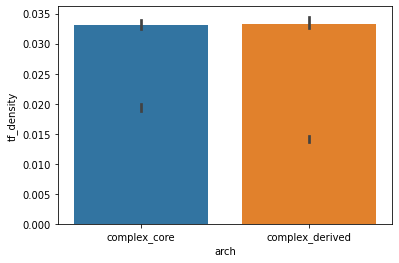

In [9]:
#%% only complex enhancers
cplx = tfden.loc[tfden.arch != 'simple']
zeros = True
plot_summarized_TFden(cplx, zeros)

#%% complex enhancer without core | der elements w/ no TFBS
cplx_ = cplx.loc[cplx.tf_density >0]
zeros = False
plot_summarized_TFden(cplx_, zeros)

#%%
table = cplx.pivot(index = "enh_id", columns = "arch", values = "tf_density")
table["sum"] = table.sum(axis = 1)

# make a table where enhancer must have TFBS evidence
# in core OR derived
table_ = table.loc[table["sum"]>0] # 20263 complex enhancers bind a TF
table_.shape

# in core AND derived TFBS evidence
table_nonzerosyn = table_.loc[
(table_["complex_core"] > 0)
& (table_["complex_derived"] > 0)
]

table_nonzerosyn.shape # (11899, 3)

# plot joint plot

In [45]:
def plot_jointplots(table, zeros, quant, kind):
    x, y = "complex_core","complex_derived",



    # plot 95% quantile of data
    dq = table["complex_derived"].quantile(quant)
    cq = table["complex_core"].quantile(quant)
    q = max([dq,cq])

    # subset table to 95% of data
    table_ = table.loc[(table["complex_derived"] <= q)
    & (table["complex_core"]<=q)]
    
    # set axis limits to max quantile of data
    lim = (0,q)

    if zeros == True:
        outf = f"{RE}sum_complex_core_v_der_den_w_zeros"
    else:
        outf = f"{RE}sum_complex_core_v_der_den_wo_zeros"

    g = sns.JointGrid(x=x, y=y, data = table_, marginal_ticks=True)
    
    g.plot_joint(sns.histplot, color = '#31a354', alpha = 0.7)

    g.plot_marginals(sns.histplot,
    edgecolor=".2", linewidth=.5,
    color = "#31a354",
    )

    # set derived histogram color
    plt.setp(g.ax_marg_y.patches, color="#addd8e", edgecolor=".2", linewidth=.5)

    t = [0, 0.05, 0.1, 0.15, 0.20]
    g.ax_joint.set_xticks(t)
    g.ax_joint.set_yticks(t)
    g.ax_joint.set_xlabel("Core TFBS density")
    g.ax_joint.set_ylabel("Derived TFBS density")

    # add KDE plot
    g.plot_joint(sns.regplot, color="k",
    marker="+", scatter_kws ={"s":0},
    )

    lin_regress(table_)

    outf_ = outf + f"_{quant}_{kind}.pdf"
    plt.savefig(outf_, bbox_inches = "tight", dpi = 60)
    plt.show()

der median 0.01639344262295082 core median 0.022026431718061675
LinregressResult(slope=0.27404933642858237, intercept=0.025857669889984315, rvalue=0.27302348690802125, pvalue=0.0, stderr=0.0071068890087759426)


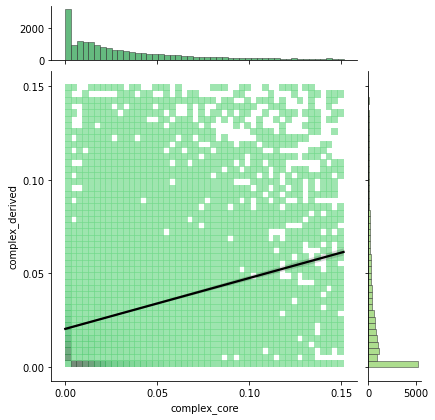

In [46]:
#%% core OR derived joint plot

#quants = [0.95, 0.75]

#kinds = ["hex", "hist", "kde", "reg", "resid"]

kind = "hist"
quant = 0.95

zeros, tble = True, table_
plot_jointplots(tble, zeros, quant, kind)

5211
3153
der median 0.03636363636363636 core median 0.03937007874015748
LinregressResult(slope=0.23408839183624744, intercept=0.04017769440564995, rvalue=0.23803829671851803, pvalue=5.113126292512663e-140, stderr=0.009157399629014611)


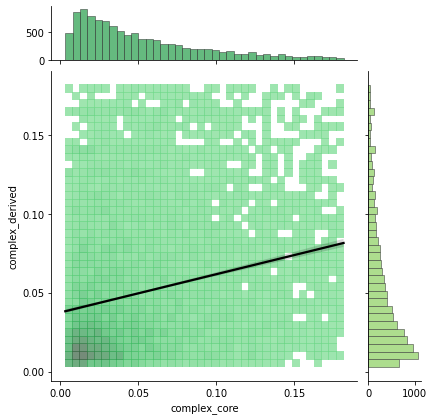

'\n# 95%\nw/0\nder median 0.01639344262295082 core median 0.022026431718061675\nLinregressResult(slope=0.2740493364285827, intercept=0.025857669889984305, rvalue=0.2730234869080214, pvalue=0.0, stderr=0.007106889008775947)\n\nw/o0\nder median 0.03636363636363636 core median 0.03937007874015748\nLinregressResult(slope=0.23408839183624733, intercept=0.04017769440564996, rvalue=0.23803829671851803, pvalue=5.113126292512663e-140, stderr=0.009157399629014606)\n\n'

In [44]:
#LinregressResult(slope=0.22504764240874248, intercept=0.03395466305726717, rvalue=0.28536843920172467, pvalue=0.0, stderr=0.005310243521041514)

#
print(len(tble.loc[tble["complex_derived"] == 0])) # 5211 = 26% of enhancers have derived sequence with no tfbs
print(len(tble.loc[tble["complex_core"] == 0])) # 3153 = 16% of enhancers have core sequence with no tfbs

# core AND derived joint plot

zeros, tble = False, table_nonzerosyn
plot_jointplots(tble, zeros, quant, kind)
#lin_regress(tble)

#%%
"""
# 95%
w/0
der median 0.01639344262295082 core median 0.022026431718061675
LinregressResult(slope=0.2740493364285827, intercept=0.025857669889984305, rvalue=0.2730234869080214, pvalue=0.0, stderr=0.007106889008775947)

w/o0
der median 0.03636363636363636 core median 0.03937007874015748
LinregressResult(slope=0.23408839183624733, intercept=0.04017769440564996, rvalue=0.23803829671851803, pvalue=5.113126292512663e-140, stderr=0.009157399629014606)

"""
#LinregressResult(slope=0.15, intercept=0.052, rvalue=0.20, pvalue=3.85e-104, stderr=0.007)
#%%